In [1]:
import sys
import os
import pandas as pd
import numpy as np
import configparser
import matplotlib.pyplot as plt
import seaborn as sns

project_root = "/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn"


# Define the project root path
current_wd = os.getcwd()

# Change the working directory if necessary
if current_wd != project_root:
    print(f"Changing working directory from {current_wd} to {project_root}")
    os.chdir(project_root)
else:
    print("Already in the correct path")

# Add 'src' directory to sys.path
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    print(f"Adding {src_path} to sys.path")
    sys.path.insert(0, src_path)

# Import the modules
from db_connectors.bigquery_service import BigqueryService
from data_gathering import data_gathering
from utils.logger import get_logger
from data_cleaning import data_cleaning
from feature_computation import feature_computation

logger = get_logger(__name__)

Changing working directory from /mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/src/eda to /mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn
Adding /mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/src to sys.path


In [2]:
query = """
    WITH selectable_customer_2022 AS (
        SELECT customer_id
        FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
        GROUP BY customer_id
    ), 
    customer_selected_2022 AS (
        SELECT customer_id AS selected_customer_2022
        FROM selectable_customer_2022
        WHERE MOD(ABS(FARM_FINGERPRINT(CAST(customer_id AS STRING))), 10) = 0
    ),
    selectable_customer_2023 AS (
        SELECT customer_id
        FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1`
        GROUP BY customer_id
    ), 
    customer_selected_2023 AS (
        SELECT customer_id AS selected_customer_2023
        FROM selectable_customer_2023
        WHERE MOD(ABS(FARM_FINGERPRINT(CAST(customer_id AS STRING))), 10) = 0
    ),
    churned_users AS (
        SELECT selected_customer_2022 AS customer_id
        FROM customer_selected_2022
        WHERE selected_customer_2022 NOT IN (SELECT selected_customer_2023 FROM customer_selected_2023)
    ),
    combined_data AS (
        SELECT 
            base2022.*,
            CASE 
                WHEN cs2022.selected_customer_2022 IN (SELECT customer_id FROM churned_users) 
                THEN TRUE 
                ELSE FALSE 
            END AS is_churned
        FROM customer_selected_2022 cs2022
        JOIN `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022` base2022
        ON cs2022.selected_customer_2022 = base2022.customer_id

        UNION ALL

        SELECT 
            base2023.*,
            FALSE AS is_churned
        FROM customer_selected_2023 cs2023
        JOIN `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1` base2023
        ON cs2023.selected_customer_2023 = base2023.customer_id
    )

    SELECT *
    FROM combined_data
    WHERE IS_CUST_SEGM_RESI > 0
    AND IS_CUST_BILL_POST_CURR = TRUE
    AND CUST_BUNDLE_CURR = 'FMC'
    AND NUM_IMPAGOS = 0
    AND pago_final_0 IS NOT NULL
"""

In [3]:
df = data_gathering(query, logger)

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 509539


In [5]:
df["NUM_DAYS_LINE_TYPE_FIXE_POST_DEA"] = df["NUM_DAYS_LINE_TYPE_FIXE_POST_DEA"].fillna(
    0
)
df["NUM_DAYS_LINE_TYPE_FIXE_POST_DEA"] = np.where(
    (df["NUM_DAYS_LINE_TYPE_FIXE_POST_DEA"] > 0),
    1,
    0,
)

In [6]:
df.head()

,brand_ds,customer_id,YEAR,MONTH,EOP,IS_CUST_SEGM_RESI,IS_CUST_SEGM_SOHO,IS_CUST_SEGM_BUSI,CHANNEL_LAST_MOBILE,CHANNEL_FIRST_MOBILE,...,MIN_NUM_DAYS_BETWEEN_FIX_PORT,NUM_PORT_OPER_DONO_PREM_TWO_YEAR_AGO,NUM_MOB_PORT_TRANS_CURR,MM_GROUP_MOB_PORT,NUM_MONTHS_SINCE_LAST_MOB_PORT_REQ,MAX_NUM_DAYS_BETWEEN_MOB_PORT_REQS,NUM_MONTHS_SINCE_LAST_MOB_PORT,MAX_NUM_MONTHS_BETWEEN_MOB_PORT_REQS,NUM_PORT_OPER_RECE_YOIGO_TWO_YEAR_AGO,is_churned
0,EUSKALTEL,3598037,2022,01,202201,1,0,0,EXCLUSIVO,OUTBOUND,...,<NA>,<NA>,<NA>,0,NaN,<NA>,NaN,NaN,<NA>,False
1,EUSKALTEL,886401,2022,10,202210,1,0,0,None,PLAT. FIDELIZACION/RETENCION,...,<NA>,<NA>,<NA>,0,NaN,<NA>,NaN,NaN,<NA>,False
2,EUSKALTEL,2295170,2022,02,202202,1,0,0,EXCLUSIVO,EXCLUSIVO,...,<NA>,<NA>,<NA>,0,NaN,<NA>,NaN,NaN,<NA>,False
3,EUSKALTEL,6145502,2022,06,202206,1,0,0,OUTBOUND,OUTBOUND,...,<NA>,0,0,0,25.000000,<NA>,25.000000,NaN,0,False
4,EUSKALTEL,7266372,2022,06,202206,1,0,0,EXCLUSIVO,EXCLUSIVO,...,<NA>,2,0,0,8.815789,7,8.815789,0.230263,0,False


In [7]:
df.groupby("YEAR")["customer_id"].count()

YEAR
2022    285057
2023    224482
Name: customer_id, dtype: int64

In [9]:
df = df.sort_values(by=["YEAR", "MONTH"])

In [10]:
df.head()

,brand_ds,customer_id,YEAR,MONTH,EOP,IS_CUST_SEGM_RESI,IS_CUST_SEGM_SOHO,IS_CUST_SEGM_BUSI,CHANNEL_LAST_MOBILE,CHANNEL_FIRST_MOBILE,...,MIN_NUM_DAYS_BETWEEN_FIX_PORT,NUM_PORT_OPER_DONO_PREM_TWO_YEAR_AGO,NUM_MOB_PORT_TRANS_CURR,MM_GROUP_MOB_PORT,NUM_MONTHS_SINCE_LAST_MOB_PORT_REQ,MAX_NUM_DAYS_BETWEEN_MOB_PORT_REQS,NUM_MONTHS_SINCE_LAST_MOB_PORT,MAX_NUM_MONTHS_BETWEEN_MOB_PORT_REQS,NUM_PORT_OPER_RECE_YOIGO_TWO_YEAR_AGO,is_churned
0,EUSKALTEL,3598037,2022,01,202201,1,0,0,EXCLUSIVO,OUTBOUND,...,<NA>,<NA>,<NA>,0,NaN,<NA>,NaN,NaN,<NA>,False
6,EUSKALTEL,7296865,2022,01,202201,1,0,0,WEB ASISTIDA INBOUND,WEB ASISTIDA INBOUND,...,<NA>,3,0,0,2.894737,0,2.894737,0.0,0,False
7,EUSKALTEL,6069295,2022,01,202201,1,0,0,PLAT. FIDELIZACION/RETENCION,PLAT. FIDELIZACION/RETENCION,...,<NA>,<NA>,<NA>,0,NaN,<NA>,NaN,NaN,<NA>,False
13,EUSKALTEL,3584080,2022,01,202201,1,0,0,PLAT. FIDELIZACION/RETENCION,PLAT. FIDELIZACION/RETENCION,...,<NA>,<NA>,<NA>,0,NaN,<NA>,NaN,NaN,<NA>,False
107,EUSKALTEL,6345827,2022,01,202201,1,0,0,WEB,WEB,...,<NA>,1,0,0,15.098684,<NA>,15.098684,NaN,0,False


In [11]:
churns = df.groupby("EOP")[["customer_id", "NUM_DAYS_LINE_TYPE_FIXE_POST_DEA"]].apply(
    lambda x: x[x["NUM_DAYS_LINE_TYPE_FIXE_POST_DEA"] > 0]["customer_id"].nunique()
)

In [12]:
churns.head()

EOP
202201     914
202202     930
202203    1094
202204     790
202205     836
dtype: int64

<Axes: xlabel='EOP'>

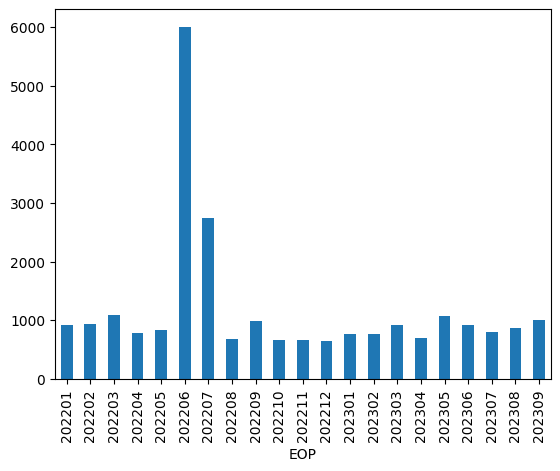

In [13]:
churns.plot(kind="bar")

In [4]:
df = data_cleaning(df, logger)

INFO - Starting cleaning data


INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column Import_Rest_quota_disp
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column NUM_FIX_PORT
INFO - Dropping column NUM_FIX_PORT_LAST_1_MONTH
INFO - Dropping column NUM_FIX_PORT_LAST_3_MONTHS
INFO - Dropping column NUM_FIX_PORT_LAST_6_MONTHS
INFO - Should fillna
INFO - Dropping column NUM_MOB_PORT
INFO - Dropping column NUM_MOB_PORT_LAST_1_MONTH
INFO - Dropp

In [5]:
save_curves_path = "src/models"
save_features_path = "src/features"
save_target_path = "src/target"

train_from = "2022-04-01"
train_to = "2022-09-01"

features, target, features_test, target_test = feature_computation(
    df,
    train_from,
    train_to,
    logger,
    save_features_path=save_features_path,
    save_target_path=save_target_path,
)

INFO - Starting feature computation
INFO - Train computation from 2022-04-01 00:00:00 to 2022-09-01 00:00:00. Target for 2022-11-01 00:00:00
INFO - Test computation from 2022-05-01 00:00:00 to 2022-10-01 00:00:00. Target for 2022-12-01 00:00:00
INFO - Removing 10492 previous churned users from train set
INFO - Removing 10423 previous churned users from test set
INFO - Unique customers in train: 14378
INFO - Unique customers in test: 14656
INFO - Starting features and target computation
INFO - Initial number of features passed: 176
INFO - Starting computation
/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/src/feature_computation.py:198: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_prev_month"] = df.groupby("customer_id")[col].shift(1)
/

In [6]:
from modeling import modeling
from evaluation import evaluation

In [7]:
lightgbm_params = {
    "boosting_type": "gbdt",
    "num_leaves": 12,
    "max_depth": -1,
    "learning_rate": 0.005,
    "n_estimators": 100,
    "random_state": 500,
    "colsample_bytree": 0.64,
    "subsample": 0.7,
    "reg_alpha": 0,
    "reg_lambda": 1,
}

INFO - Starting Modeling
INFO - Building model pipeline
INFO - Training model


[LightGBM] [Info] Number of positive: 353, number of negative: 13188
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66155
[LightGBM] [Info] Number of data points in the train set: 13541, number of used features: 345
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.026069 -> initscore=-3.620595
[LightGBM] [Info] Start training from score -3.620595


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


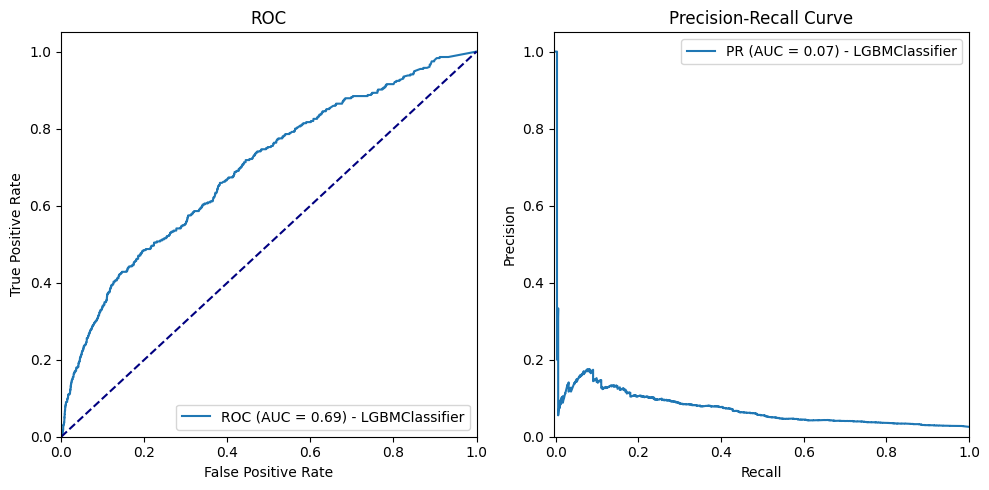

INFO - Precision in the first decile: 0.08
/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_churn_rate = data_sorted.groupby("decile")["y_true"].mean()
INFO - Uplift by decile:
INFO - decile
0    3.266425
1    1.493497
2    0.732130
3    1.127984
4    0.873555
5    0.675324
6    0.632286
7    0.359315
8    0.591336
9    0.253430
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                 Feature  Coefficient
43                   MAX_DAYS_PERM_CURR           75
112                       NUM_PERM_CURR           67
38                   MIN_DAYS_PERM_CURR           58
3                           periodica_0           50
115                        NUM_PREV_O

In [8]:
model = modeling(features, target, lightgbm_params, logger)
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path
)

In [9]:
feature_importance_2 = feature_importance.sort_values(
    by="Coefficient", ascending=False
).head(20)

In [10]:
feature_importance_2

,Feature,Coefficient
43,MAX_DAYS_PERM_CURR,75
112,NUM_PERM_CURR,67
38,MIN_DAYS_PERM_CURR,58
3,periodica_0,50
115,NUM_PREV_OBJ,38
168,service_fix_pending_install_6month,38
152,dif_periodica_prev_3_month,37
164,service_fix_pending_install_3month,35
284,NUM_PLAT_GMM_CURR_std_3_months,25
0,pago_final_0,20


<Axes: xlabel='Coefficient', ylabel='Feature'>

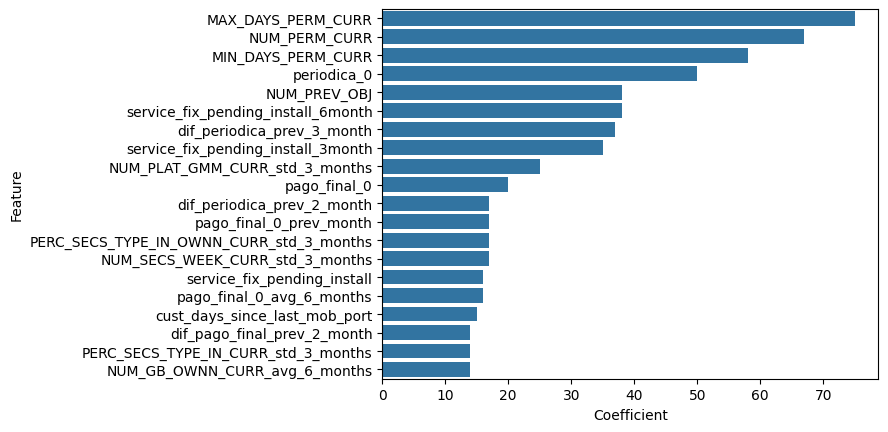

In [11]:
sns.barplot(
    feature_importance_2,
    x="Coefficient",
    y="Feature",
)

In [12]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [13]:
shap_values = shap.TreeExplainer(model.named_steps["lightgbm"]).shap_values(
    features_test
)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


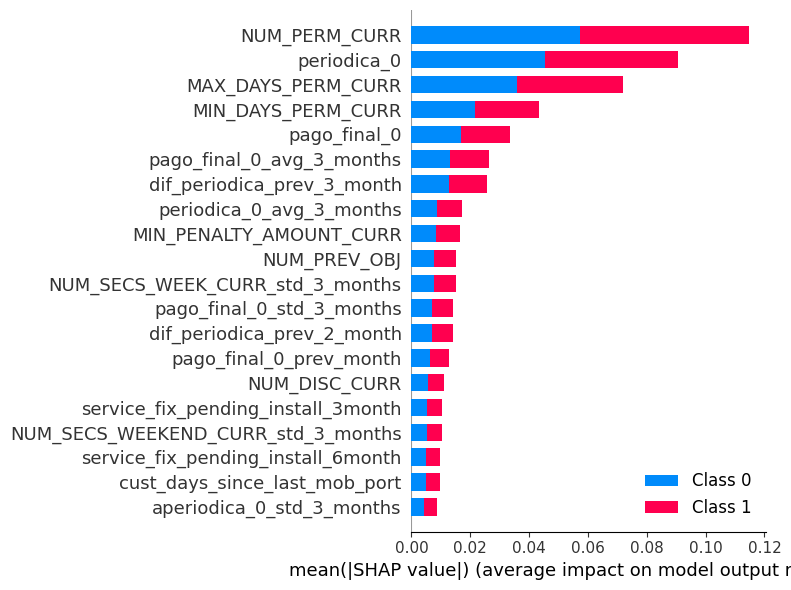

In [14]:
shap.summary_plot(shap_values, features_test, plot_size=[8, 6])

In [15]:
def get_shap_values(model, features):
    explainer = shap.Explainer(model)
    shap_values = explainer(features)

    return shap_values[:, :, 1]

In [16]:
for col in features_test.columns:
    features_test[col] = features_test[col].astype(float)

In [17]:
sv = get_shap_values(model.named_steps["lightgbm"], features_test)

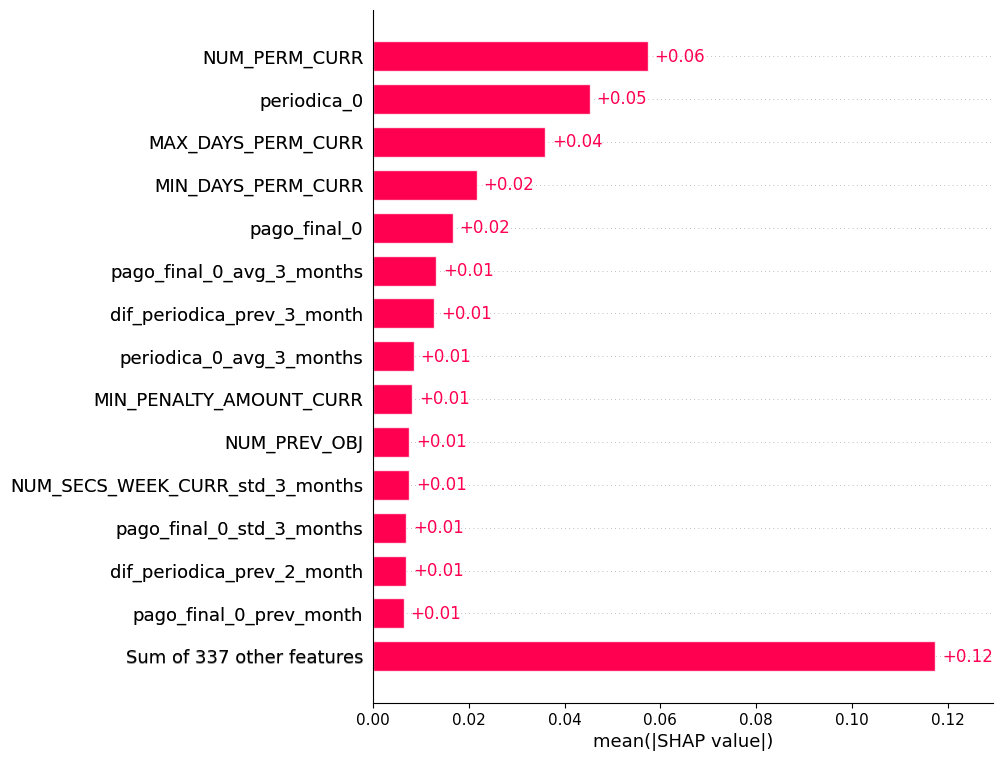

In [18]:
shap.plots.bar(sv, max_display=15)

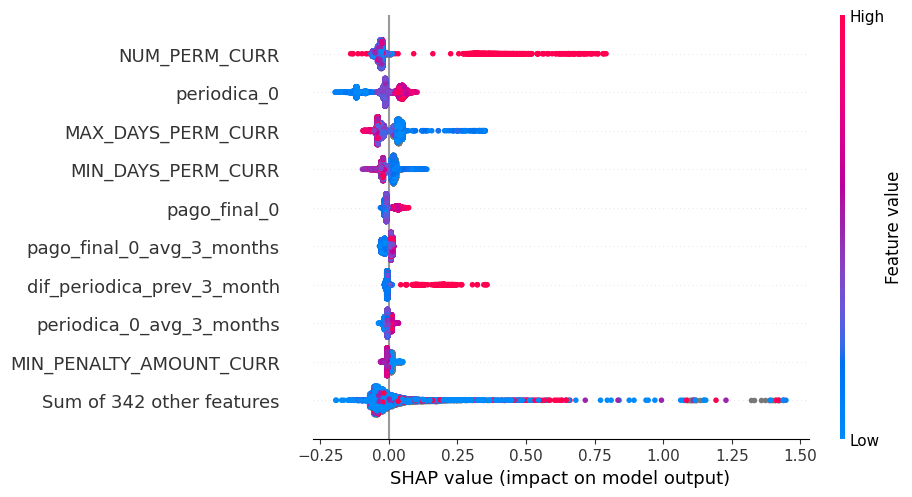

In [19]:
shap.plots.beeswarm(sv)

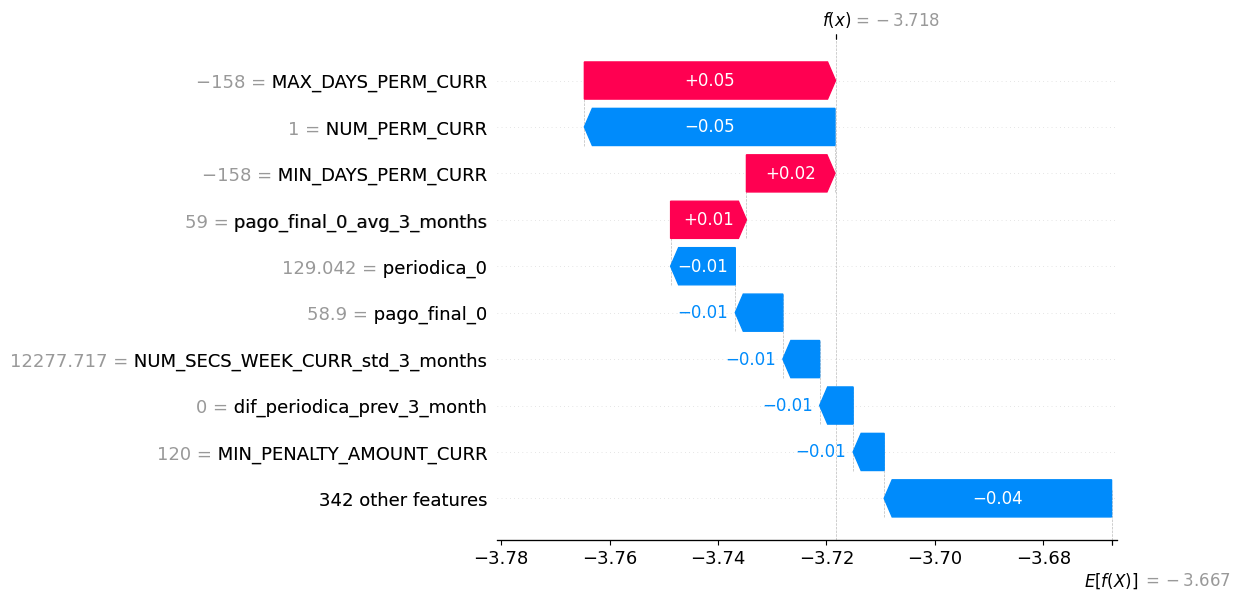

In [44]:
shap.plots.waterfall(sv[0])

In [45]:
preds = model.predict_proba(features_test)[:, 1]

In [46]:
data = pd.DataFrame({"y_true": target_test, "y_pred_proba": preds})
data_sorted = data.sort_values(by="y_pred_proba", ascending=False)

In [49]:
data_sorted[data_sorted["y_true"] == 1]

,y_true,y_pred_proba
4788,1.0,0.156707
2151,1.0,0.129242
13713,1.0,0.103645
9074,1.0,0.099681
2998,1.0,0.090289
...,...,...
8606,1.0,0.019444
8769,1.0,0.019444
7961,1.0,0.019444
7176,1.0,0.019444


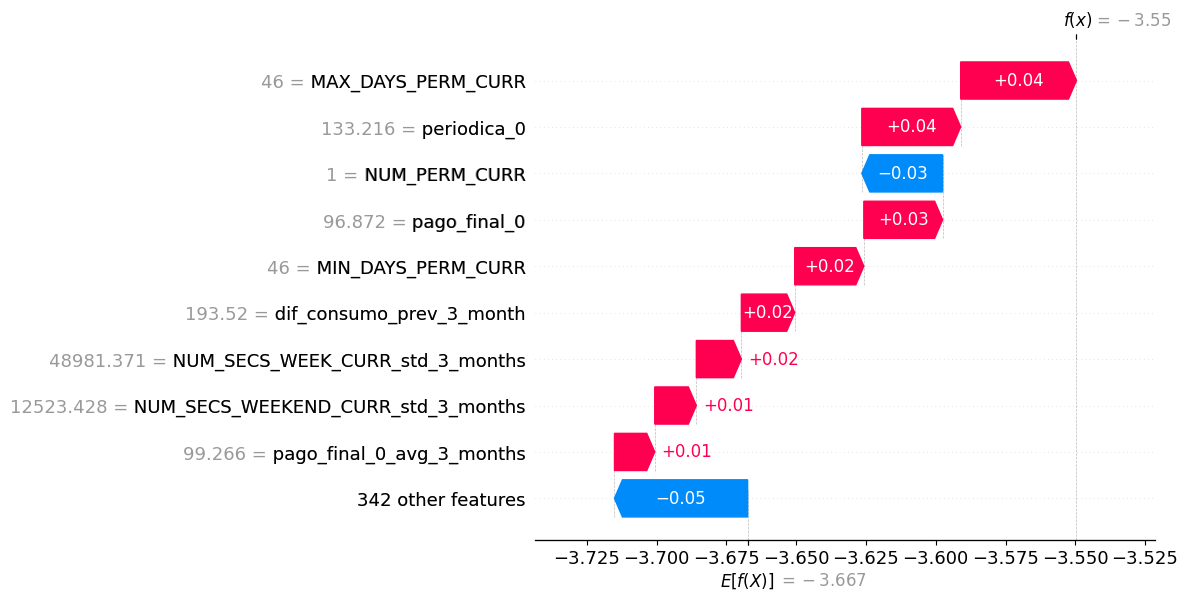

In [53]:
shap.plots.waterfall(sv[2151])